In [8]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import figure
import glob
import os
import metpy
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from datetime import datetime
import xarray as xr
from pint import UnitRegistry
ureg = UnitRegistry()
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.api as sm
import string

In [9]:
# Define file paths
file1 = "C:\\YEAR1\\NMVOC\\Data\\data_Meteo\\processed_met_11_23.csv"
file2 = "C:\\YEAR1\\NMVOC\\Data\\processed_c3h8.csv"

# Read meteo data, parse 'DATETIME' as datetime, and set as index
df1 = pd.read_csv(file1, parse_dates=['DATETIME'])
df1 = df1.set_index('DATETIME')
df1 = df1.reset_index().rename(columns={'DATETIME': 'datetime'})  # ensure column is named 'datetime'

# Read C3H8 data, parse 'datetime' as datetime
df2 = pd.read_csv(file2, parse_dates=['datetime'])

# Merge all datasets on 'datetime' using an inner join
merged_df = df1.merge(df2, on='datetime', how='inner')

# Display result
print(merged_df)

                 datetime  wind_speed  temperature  relative_humidity  \
0     2011-01-27 09:00:00       11.50        -7.30              96.05   
1     2011-01-27 11:00:00       12.50        -6.70              96.70   
2     2011-01-27 13:00:00       20.05        -6.55              96.75   
3     2011-01-27 15:00:00       13.45        -6.35              96.45   
4     2011-01-27 17:00:00       34.10        -7.00              96.00   
...                   ...         ...          ...                ...   
35042 2023-12-31 02:00:00        7.33         3.38              86.00   
35043 2023-12-31 04:00:00        8.13         3.32              87.00   
35044 2023-12-31 05:00:00        7.51         3.48              86.00   
35045 2023-12-31 07:00:00        4.39         2.88              90.00   
35046 2023-12-31 08:00:00        3.83         3.12              88.00   

       pressure  C3H8_ppb  
0        781.50   0.67476  
1        781.95   0.71596  
2        781.25   0.72782  
3        78

In [10]:
# Convert 'DATETIME' column to datetime if not already
merged_df["datetime"] = pd.to_datetime(merged_df["datetime"])
# helper columns with  hour, month, year
merged_df['hour'] = merged_df['datetime'].dt.hour
merged_df['month'] = merged_df['datetime'].dt.month
merged_df['year'] = merged_df['datetime'].dt.year
merged_df['date'] = merged_df['datetime'].dt.date
merged_df['dayofyear'] = merged_df['datetime'].dt.date 
merged_df

,datetime,wind_speed,temperature,relative_humidity,pressure,C3H8_ppb,hour,month,year,date,dayofyear
0,2011-01-27 09:00:00,11.50,-7.30,96.05,781.50,0.67476,9,1,2011,2011-01-27,2011-01-27
1,2011-01-27 11:00:00,12.50,-6.70,96.70,781.95,0.71596,11,1,2011,2011-01-27,2011-01-27
2,2011-01-27 13:00:00,20.05,-6.55,96.75,781.25,0.72782,13,1,2011,2011-01-27,2011-01-27
3,2011-01-27 15:00:00,13.45,-6.35,96.45,780.75,0.72500,15,1,2011,2011-01-27,2011-01-27
4,2011-01-27 17:00:00,34.10,-7.00,96.00,780.20,0.74131,17,1,2011,2011-01-27,2011-01-27
...,...,...,...,...,...,...,...,...,...,...,...
35042,2023-12-31 02:00:00,7.33,3.38,86.00,796.79,0.07656,2,12,2023,2023-12-31,2023-12-31
35043,2023-12-31 04:00:00,8.13,3.32,87.00,796.59,0.11815,4,12,2023,2023-12-31,2023-12-31
35044,2023-12-31 05:00:00,7.51,3.48,86.00,796.42,0.10664,5,12,2023,2023-12-31,2023-12-31
35045,2023-12-31 07:00:00,4.39,2.88,90.00,796.21,0.10012,7,12,2023,2023-12-31,2023-12-31


In [11]:
# Ensure 'date' is datetime
merged_df['date'] = pd.to_datetime(merged_df['date'])

# Add season (DJF, MAM, JJA, SON)

# Define season function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

merged_df['season'] = merged_df['month'].apply(get_season)

In [12]:

# select the days with daily C3h8 average exceeding the 96th quantile
# https://doi.org/10.1016/j.atmosenv.2021.118245

# Group by date to get daily average
daily_avg = merged_df.groupby('date').agg({'C3H8_ppb': 'mean'}).rename(columns={'C3H8_ppb': 'daily_avg'})
daily_avg = daily_avg.reset_index()

# Re-merge to get season and year for each day
daily_avg['year'] = daily_avg['date'].dt.year
daily_avg['month'] = daily_avg['date'].dt.month
daily_avg['season'] = daily_avg['month'].apply(get_season)

#  1. Compute daily means of c3h8_ppt
daily = merged_df.groupby(['date', 'year', 'season'])['C3H8_ppb'].mean().reset_index()
daily.rename(columns={'C3H8_ppb': 'daily_mean'}, inplace=True)

# 2. Compute Q96 per season
q96 = daily.groupby(['season'])['daily_mean'].quantile(0.96).reset_index()
q96.rename(columns={'daily_mean': 'q96'}, inplace=True)

# 3. Merge Q96 with daily means
merged = daily.merge(q96, on=['season'], how='left')

# 4. Count exceedances
merged['above_q96'] = merged['daily_mean'] > merged['q96']
summary = merged.groupby(['year', 'season']).agg(
    q96=('q96', 'first'),
    count_above_q96=('above_q96', 'sum')
).reset_index()


# 5. Print result
#print(summary.sort_values(['year', 'season']))

In [ ]:
merged

In [13]:

# Step 1: Make sure 'date' is properly typed
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.date
merged['date'] = pd.to_datetime(merged['date']).dt.date


# Now safely merge
df_labeled = pd.merge(
    merged_df,
    merged[['date', 'above_q96']],
    on='date',
    how='left'
)

# Step 3: Compute descriptive statistics for temperature, pressure, wind_speed
# Group by outlier status and season_x (from merged_df)
stats = (
    df_labeled
    .groupby(['above_q96'])[['temperature', 'pressure', 'wind_speed']]
    .describe()
)

# Optional: flatten MultiIndex columns for readability
stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = stats.reset_index()

# Show result
print(stats)

   above_q96  temperature_count  temperature_mean  temperature_std  \
0      False            32538.0          4.655547         6.485596   
1       True             1187.0          1.712452         7.783862   

   temperature_min  temperature_25%  temperature_50%  temperature_75%  \
0            -18.2           -0.400              4.5            9.700   
1            -16.5           -3.275             -0.5            8.565   

   temperature_max  pressure_count  ...  pressure_75%  pressure_max  \
0             23.2         32538.0  ...       793.090         805.5   
1             20.8          1187.0  ...       791.475         804.4   

   wind_speed_count  wind_speed_mean  wind_speed_std  wind_speed_min  \
0           32538.0         6.487288        4.774922             0.0   
1            1187.0         8.547515        6.247801             0.0   

   wind_speed_25%  wind_speed_50%  wind_speed_75%  wind_speed_max  
0           3.100             5.2           8.470            53.2  
1 

C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_2012\2489852643.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_2012\2489852643.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_2012\2489852643.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\EnricoMancinelli\AppData\Local\Temp\ipykernel_2012\2489852643.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed i

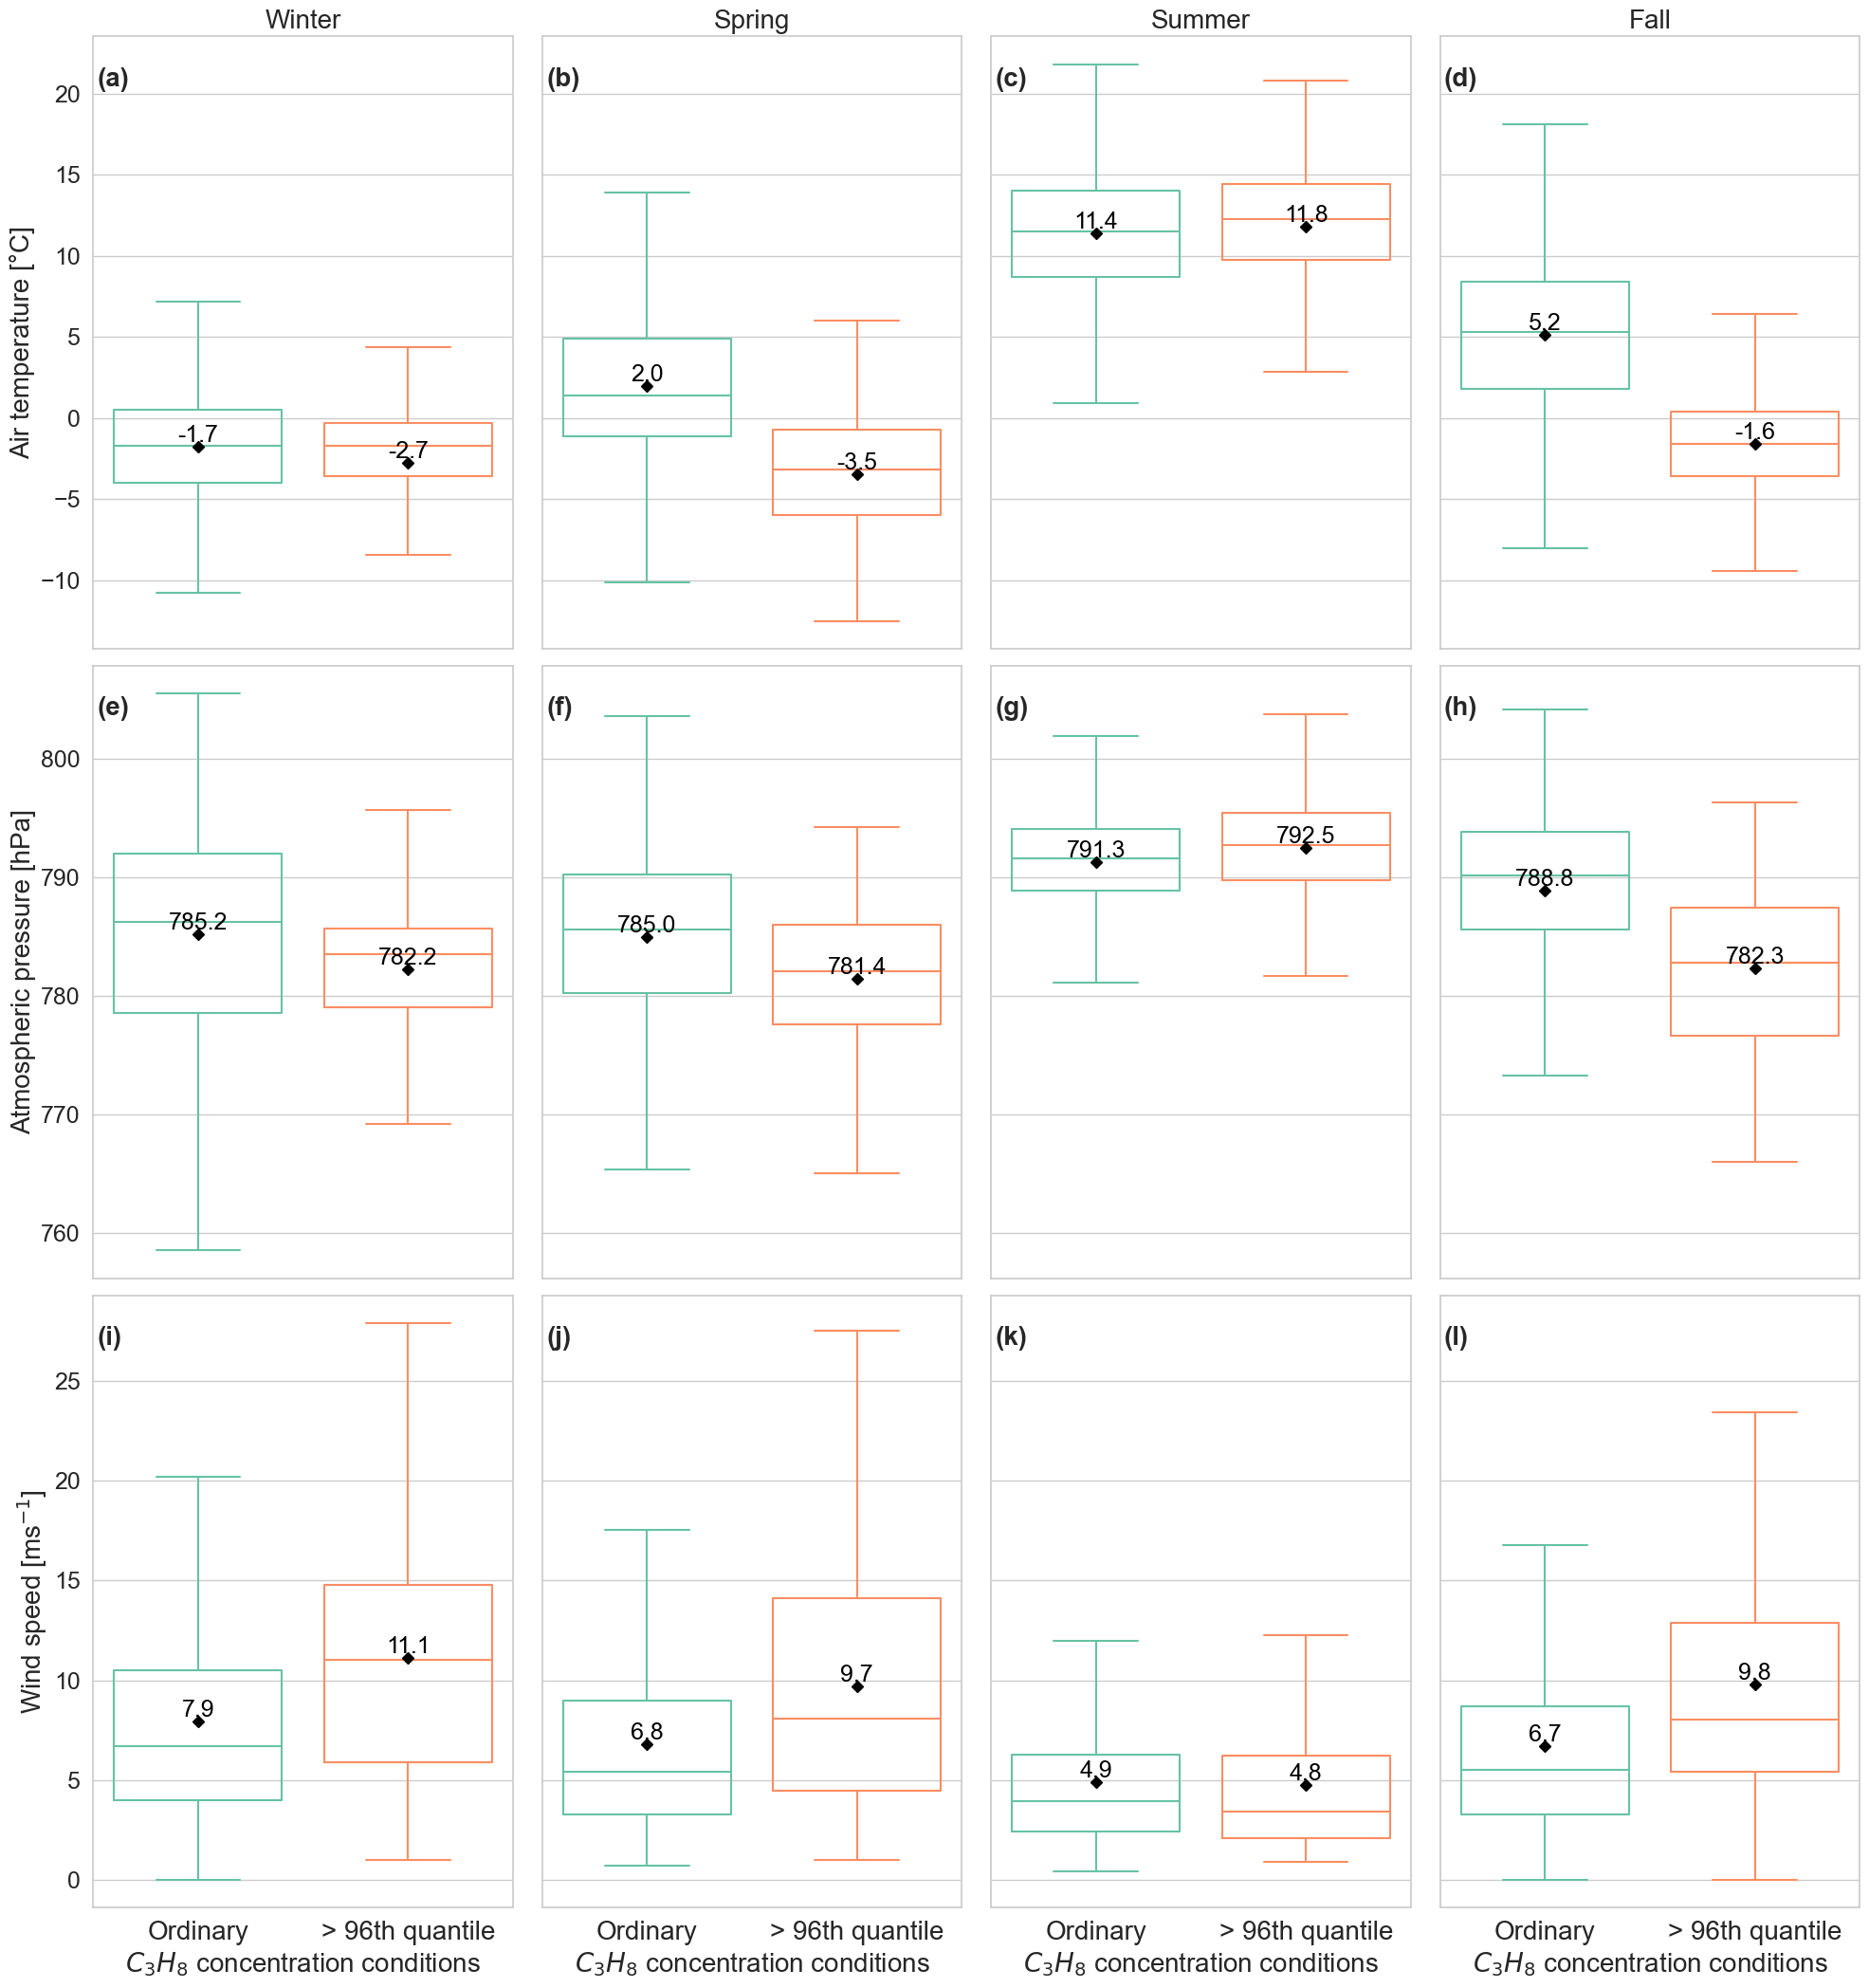

In [14]:

# Set style
sns.set(style="whitegrid")

# Setup
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
variables = ['temperature', 'pressure', 'wind_speed']
event_order = [False, True]
event_labels = {False: 'Ordinary', True: '> 96th quantile'}

# Rename column values for better labels
df_labeled['event_label'] = df_labeled['above_q96'].map(event_labels)

# Custom axis labels
y_labels = {
    'temperature': 'Air temperature [°C]',
    'pressure': 'Atmospheric pressure [hPa]',
    'wind_speed': 'Wind speed [ms$^{-1}$]'
}
x_label = "$C_3H_8$ concentration conditions"

# Plot setup
fig, axes = plt.subplots(3, 4, figsize=(20, 22), sharey='row')
fig.subplots_adjust(hspace=0.4, wspace=0.3)
panel_labels = list(string.ascii_lowercase)
label_index = 0

# Loop through variables and seasons
for i, var in enumerate(variables):  # rows
    for j, season in enumerate(season_order):  # columns
        ax = axes[i, j]
        subset = df_labeled[df_labeled['season'] == season]

        # Create boxplot
        sns.boxplot(
            data=subset,
            x='event_label',
            y=var,
            order=[event_labels[o] for o in event_order],
            ax=ax,
            palette='Set2',
            fill=False,
            showfliers=False,
            showmeans=True,
            meanprops={
                "marker": "D",
                "markerfacecolor": "black",
                "markeredgecolor": "black",
                "markersize": 6
            }
        )

        # Panel label (e.g., (a))
        ax.text(0.01, 0.95, f"({panel_labels[label_index]})",
                transform=ax.transAxes, fontsize=20, fontweight='bold', va='top')
        label_index += 1

        # Only first row has season titles
        if i == 0:
            ax.set_title(f'{season}', fontsize=20)
        else:
            ax.set_title("")
        

        # Y-axis label only in first column
        if j == 0:
            ax.set_ylabel(y_labels[var], fontsize=20)
            ax.tick_params(axis='y', labelleft=True)
        else:
            ax.set_ylabel("")
            ax.tick_params(axis='y', labelleft=False)

        ax.tick_params(axis='y', labelsize=18)

        # X-axis: only bottom row gets label
        if i == 2:
            ax.set_xlabel(x_label, fontsize=20)
        else:
            ax.set_xlabel("")
        # X-axis: only bottom row gets tick labels
        if i == 2:
            ax.set_xticklabels([event_labels[o] for o in event_order], fontsize=16)
        else:
            ax.set_xticklabels([])
        # ✅ Set x-axis tick label font size
        ax.tick_params(axis='x', labelsize=20)
        # Annotate mean values near diamond markers
        grouped = subset.groupby('event_label')[var].mean()
        for xtick, event in enumerate([event_labels[o] for o in event_order]):
            mean_val = grouped.get(event, None)
            if mean_val is not None:
                ax.text(
                    xtick, mean_val, f"{mean_val:.1f}",
                    ha='center', va='bottom',
                    fontsize=18, color='black'
                )

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("C:\\YEAR1\\NMVOC\\figures\\meteo_anom_high_even_c3h8_month.png", dpi=300)
plt.show()